In [1]:
import numpy as np
import pandas as pd
import h5py
import sys
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from statistics import mean
import scipy
from pathlib import Path
import math
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.optimize import Bounds
from scipy.fft import fft, fftfreq
from mpl_toolkits.mplot3d import Axes3D
from scipy import signal 
from scipy.signal import lombscargle
import operator
import riip

In [2]:
#Plotting Options
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.style.use('seaborn-whitegrid')

textwidth = 5.9

plt.rc('font', size=SMALL_SIZE)
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

plt.rcParams["font.family"] = "Times"

from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

wls = np.linspace(1.01,22,61)

## Refractive Index

Import refractive index data to build expected retardance arrays

In [3]:
ri = riip.RiiDataFrame()

In [4]:
ri.search("Ca")

,book,section,page,formula,tabulated,wl_min,wl_max
id,,,,,,,
65,CdGeAs2,,Boyd-o,2,f,2.400000,11.500
66,CdGeAs2,,Boyd-e,2,f,2.400000,11.500
131,C,Diamond,Phillip,0,nk,0.035424,10.000
132,C,Diamond,Peter,1,f,0.226000,0.760
133,C,CVD Diamond,Dore,0,nk,2.500000,500.000
...,...,...,...,...,...,...,...
2795,HAC,,Smith-Ta750C,0,nk,0.261000,0.827
2851,fused_silica_matching_liquid,,Cargille-06350,5,f,0.225000,1.550
2852,fused_silica_matching_liquid,,Cargille-50350,5,f,0.225000,1.550


In [5]:
CdSe_o = ri.material({'id': 662})
CdSe_e = ri.material({'id': 663})

Te_o = ri.material({'id': 747})
Te_e = ri.material({'id': 748})


birefringence = interp1d(wls, CdSe_e.n(wls)-CdSe_o.n(wls), kind='cubic')


Extinction coefficient is missing and set to zero.
Extinction coefficient is missing and set to zero.
Extinction coefficient is missing and set to zero.
Extinction coefficient is missing and set to zero.


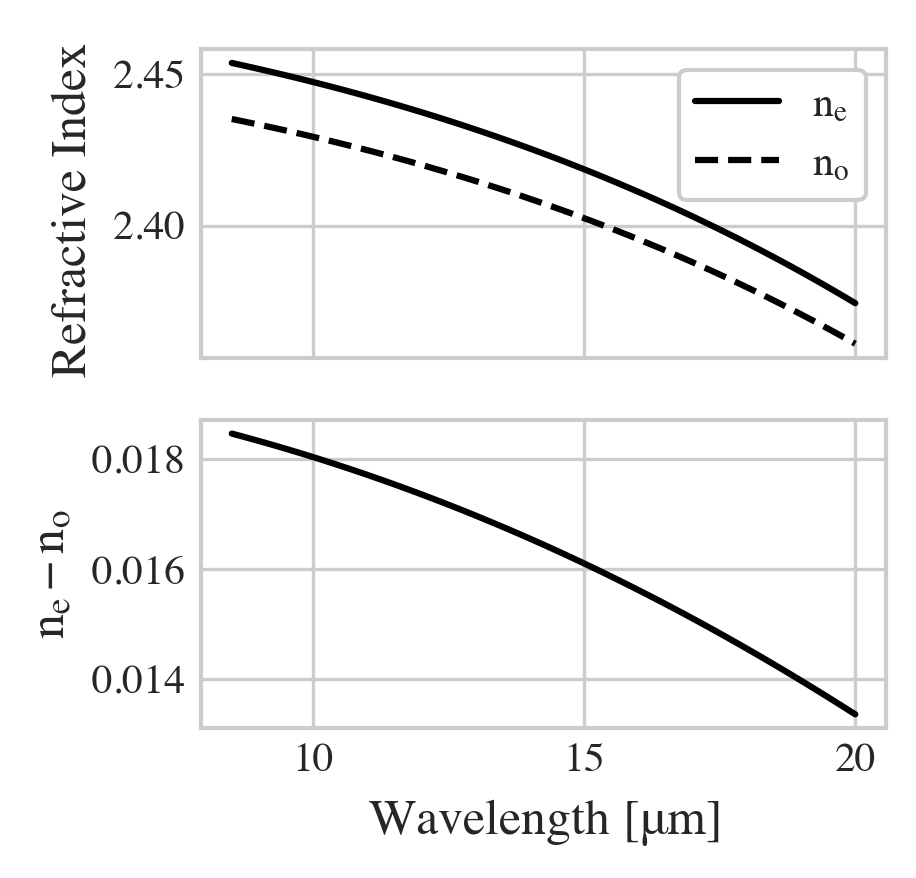

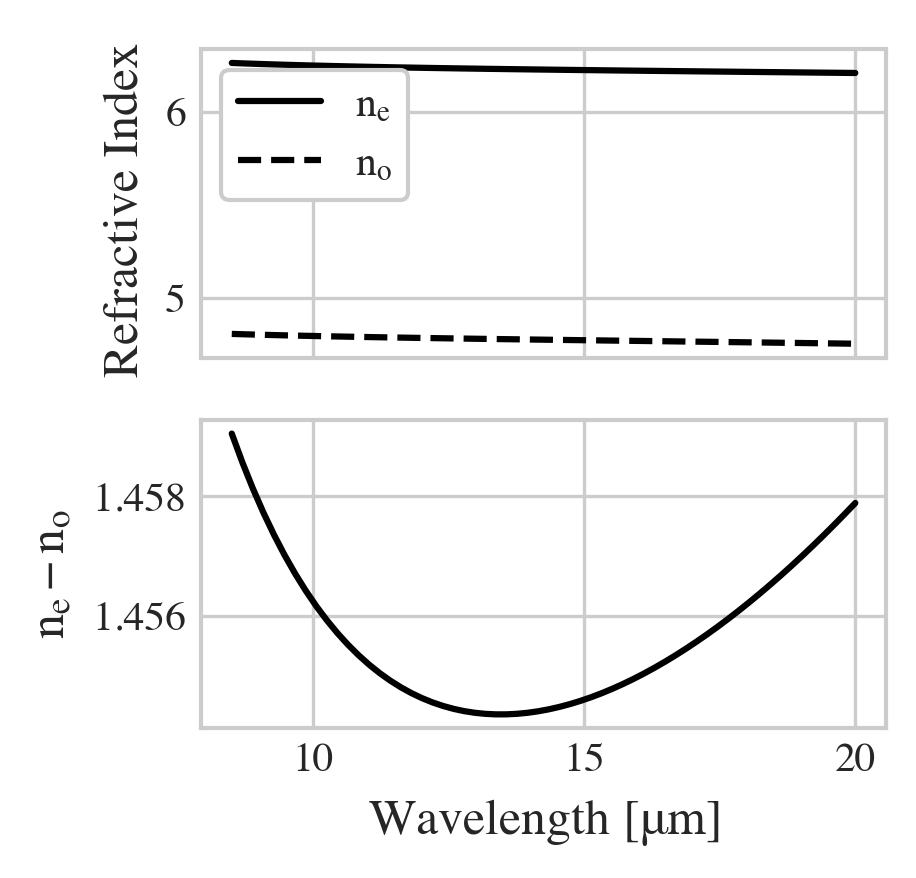

In [14]:
fig, axs = plt.subplots(2,figsize = (textwidth/2 ,3),sharex = True)
axs[0].plot(wls,CdSe_e.n(wls),'k-',label = '$\mathdefault{n_e}$')
axs[0].plot(wls,CdSe_o.n(wls),'k--',label ='$\mathdefault{n_o}$')
axs[0].set_ylabel('Refractive Index ')
axs[0].grid(True)

axs[1].plot(wls,CdSe_e.n(wls)-CdSe_o.n(wls),'k',label = '$\Delta n')
axs[1].set_xlabel('Wavelength [$\mathdefault{\mu}$m]')
axs[1].set_ylabel('$\mathdefault{n_e - n_o}$')
axs[1].grid(True)
plt.gcf().set_dpi(300)
legend = axs[0].legend(framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
#fig.suptitle("CdSe Birefringence")
plt.show()


wls = np.linspace(8.5,20,60)
fig, axs = plt.subplots(2,figsize = (textwidth/2 ,3),sharex = True)
axs[0].plot(wls,Te_e.n(wls),'k-',label = '$\mathdefault{n_e}$')
axs[0].plot(wls,Te_o.n(wls),'k--',label ='$\mathdefault{n_o}$')
axs[0].set_ylabel('Refractive Index ')
axs[0].grid(True)

axs[1].plot(wls,Te_e.n(wls)-Te_o.n(wls),'k',label = '$\Delta n')
axs[1].set_xlabel('Wavelength [$\mathdefault{\mu}$m]')
axs[1].set_ylabel('$\mathdefault{n_e - n_o}$')
axs[1].grid(True)
plt.gcf().set_dpi(300)
legend = axs[0].legend(framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')
#fig.suptitle("CdSe Birefringence")
plt.show()

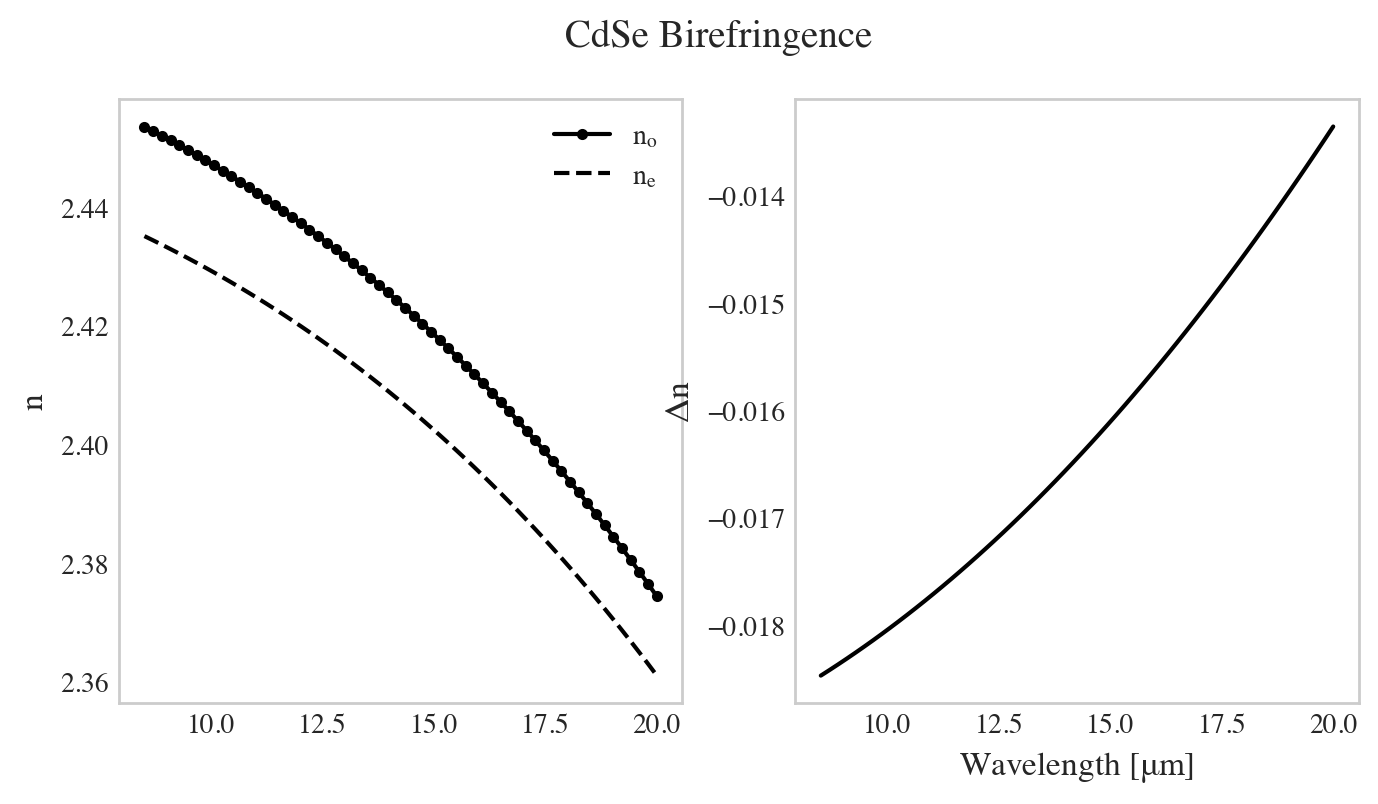

In [15]:
fig, axs = plt.subplots(1,2,figsize = (8,4),sharex = True)
axs[0].plot(wls,CdSe_e.n(wls),'k.-',label = '$\mathdefault{n_o}$')
axs[0].plot(wls,CdSe_o.n(wls),'k--',label ='$\mathdefault{n_e}$')
axs[0].set_ylabel('n')
axs[0].grid()

axs[1].plot(wls,CdSe_o.n(wls)-CdSe_e.n(wls),'k',label = '$\Delta n')
axs[1].set_xlabel('Wavelength [$\mathdefault{\mu}$m]')
axs[1].set_ylabel('$\mathdefault{\Delta n}$')
axs[1].grid()
plt.gcf().set_dpi(200)
legend =axs[0].legend()
legend.get_frame().set_facecolor('w')
fig.suptitle("CdSe Birefringence")
plt.show()

In [16]:
def retardance(wavelength,thick):
    d = float(birefringence(wavelength))
    return(thick*d*1000)

In [17]:
wls = np.linspace(7,13,100)

ret5 = list(map(lambda x: retardance(x,5.01)/x, wls))
ret6 = list(map(lambda x: retardance(x,6.01)/x, wls))
ret7 = list(map(lambda x: retardance(x,7.01)/x, wls))

fqs = 10**4/(wls)
df5 =np.mean(np.diff(ret5)/np.diff(fqs))
df6 =np.mean(np.diff(ret6)/np.diff(fqs))

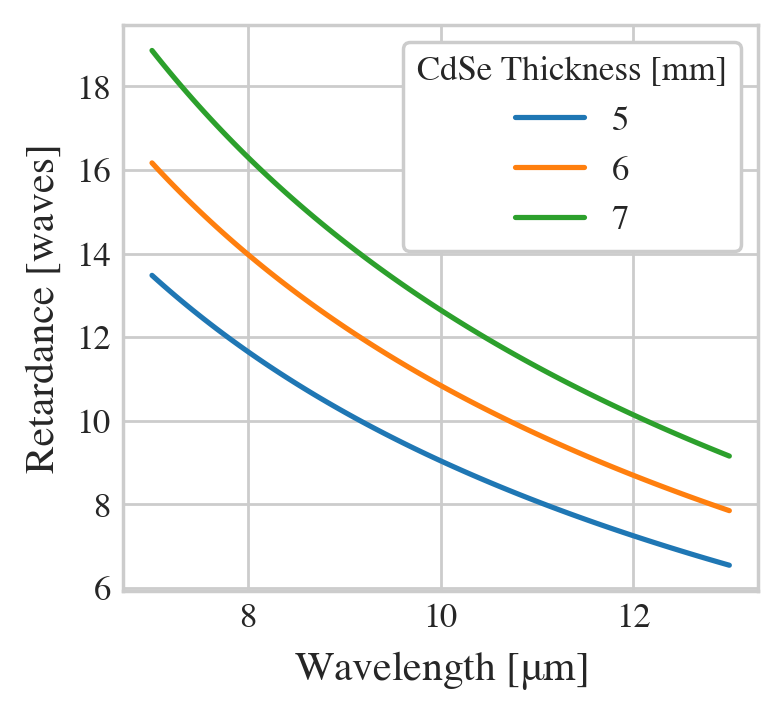

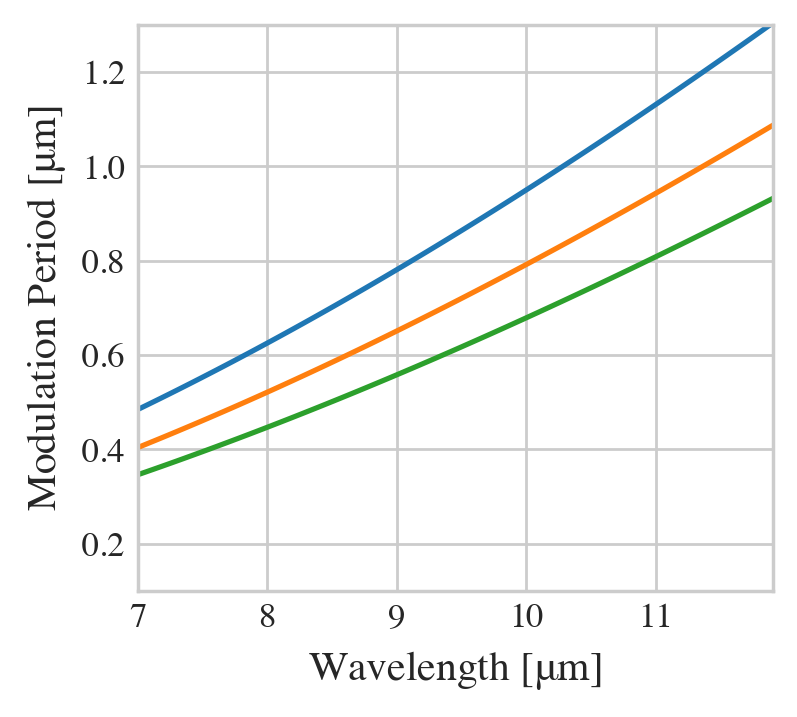

In [21]:
fig = plt.subplots(1,figsize = (textwidth/1.8 ,3))
plt.plot(wls,ret5,label = "5")
plt.plot(wls,ret6,label = "6")
plt.plot(wls,ret7,label = "7")
plt.ylabel("Retardance [waves]")
plt.xlabel('Wavelength [$\mathdefault{\mu m}$]')
legend = plt.legend(framealpha=1, frameon=True,title = "CdSe Thickness [mm]")
legend.get_frame().set_facecolor('w')
plt.gcf().set_dpi(250)
plt.show()

x = wls[:-1]

fig = plt.subplots(1,figsize = (textwidth/1.8 ,3))
plt.plot(x,-1/(np.diff(ret5)/np.diff(wls)),label = "5")
plt.plot(x,-1/(np.diff(ret6)/np.diff(wls)),label = "7")
plt.plot(x,-1/(np.diff(ret7)/np.diff(wls)),label = "9")
plt.ylabel("Modulation Period [$\mathdefault{\mu m}$]")
plt.xlabel('Wavelength [$\mathdefault{\mu m}$]')
#plt.legend(title = "CdSe Thickness [mm]")
plt.ylim(.1,1.3)
plt.xlim(7,11.9)
#plt.fill_between(x,1, 1.4,alpha = .1,color='k')
#plt.fill_between(x,0, 0.6,alpha = .1,color='k')
plt.gcf().set_dpi(250)

## CD Model

In [22]:
#The Demodulation Kernals 
def I1(lambda_c,thick,aolp = 0):
    delta = 2*math.pi * retardance(lambda_c,thick) /lambda_c
    return(1+np.cos(delta+2*aolp))

def I2(lambda_c,thick,aolp = 0):
    delta = 2*math.pi * retardance(lambda_c,thick) /lambda_c
    return(1-np.cos(delta+2*aolp))

In [23]:
res = 1000
xpos = np.linspace(0,61,61*res);

In [24]:
def pos(lambda_c):
    return(61*res/5 *(lambda_c-7))

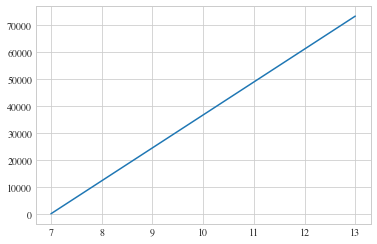

In [25]:
plt.plot(wls,pos(wls))

In [28]:
#width is in pixels
xpos = np.linspace(0,61*.012,61*res);
def PSF(lambda_c,width):
    x0 = pos(lambda_c)/res
    w = width
    return(np.sinc((xpos-x0)/(w))**2)

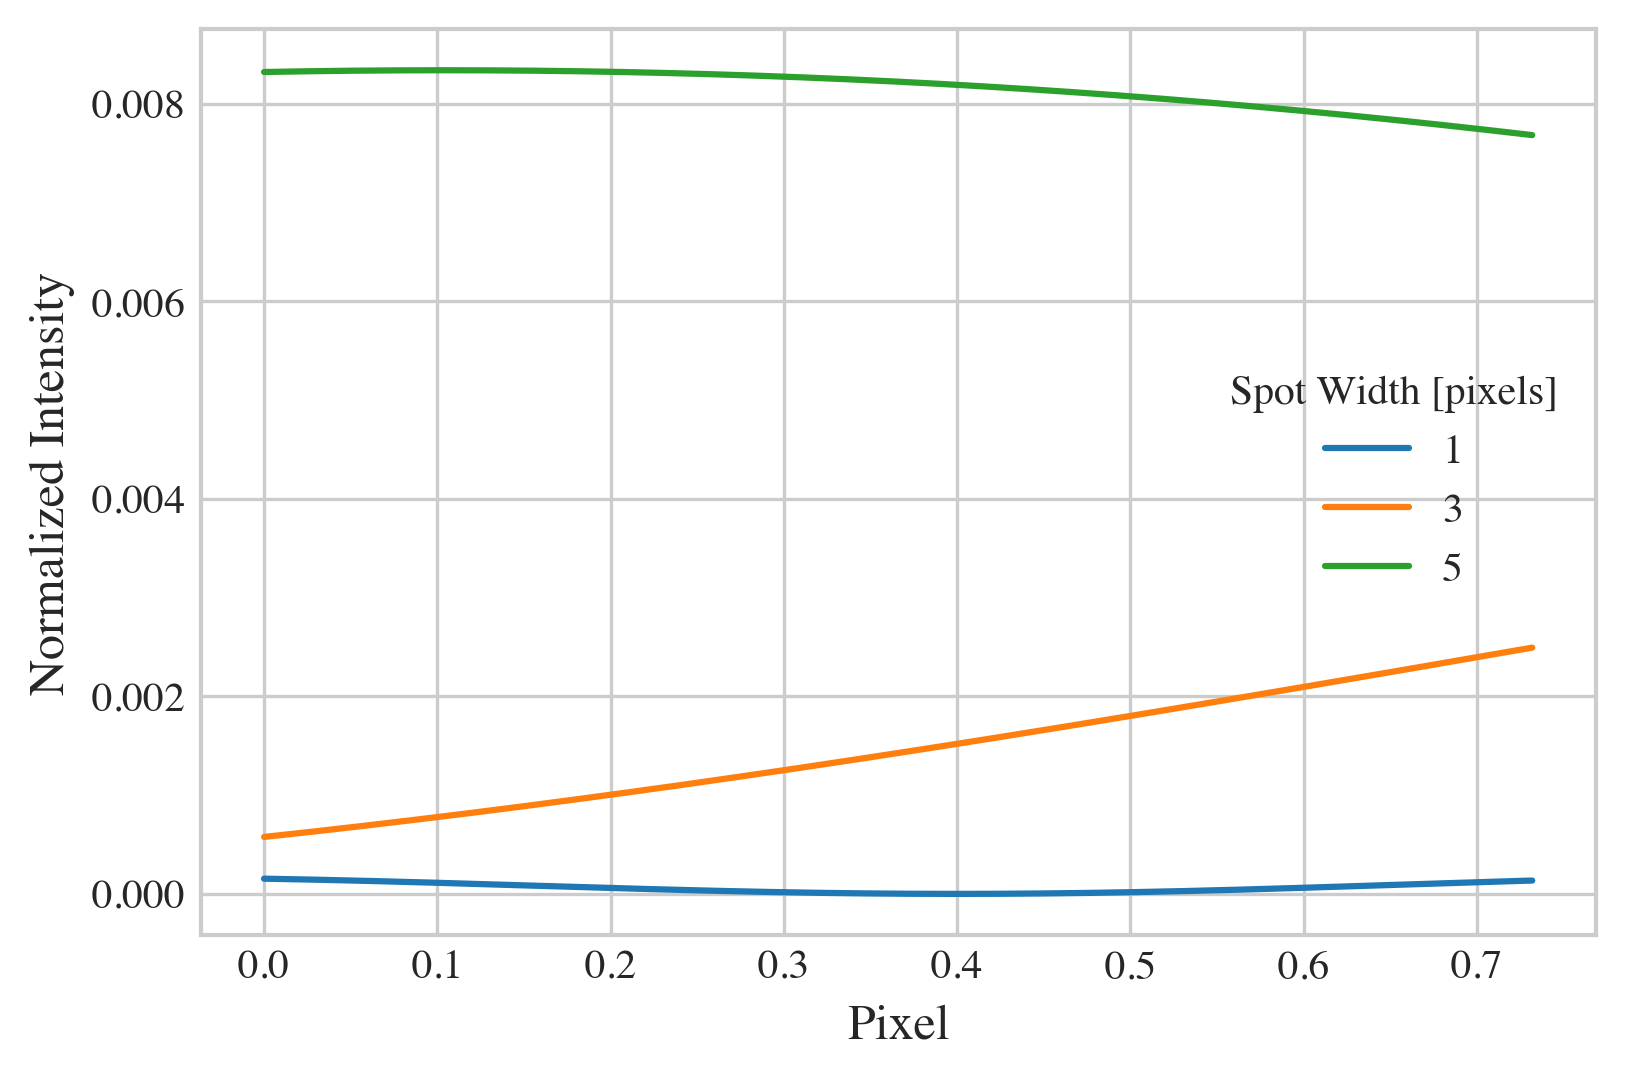

In [29]:
plt.plot(xpos ,PSF(9,1),label = '1')
plt.plot(xpos,PSF(9,5),label = '3')
plt.plot(xpos,PSF(9,7),label = '5')

plt.ylabel("Normalized Intensity")
plt.xlabel('Pixel')
plt.legend(title = "Spot Width [pixels]")
plt.gcf().set_dpi(300)

plt.show()

In [660]:
width = 1

def average(arr, n):
    end =  n * int(len(arr)/n)
    return np.mean(arr[:end].reshape(-1, n), 1)

def mod(width,thick,aolp = 0):
    S1 = np.zeros(61*res)
    S2 = np.zeros(61*res)
    for l in np.linspace(7,12,100):
        i1 = I1(l,thick,aolp)
        i2 = I2(l,thick,aolp)
        S1 = S1 + thick*i1*PSF(l,width)
        S2 = S2 + thick*i2*PSF(l,width)
    N = 1000;
    S1 = average(S1, N)
    S2 = average(S2, N)
    return((S1-S2)/(S1+S2),np.max(S1))

def mod_continuous(thick,aolp = 0):
    S1 = np.zeros(200)
    S2 = np.zeros(200)
    j = 0
    for l in np.linspace(7,12,200):
        i1 = I1(l,thick,aolp)
        i2 = I2(l,thick,aolp)
        S1[j] = i1
        S2[j] = i2
        j = j+1
    return((S1-S2)/(S1+S2))

def path_continuous(thick,aolp = 0):
    S1 = np.zeros(61)
    S2 = np.zeros(61)
    j = 0
    for l in np.linspace(7,12,61):
        i1 = I1(l,thick,aolp)
        i2 = I2(l,thick,aolp)
        S1[j] = i1
        S2[j] = i2
        j = j+1
    return([S1,S2])

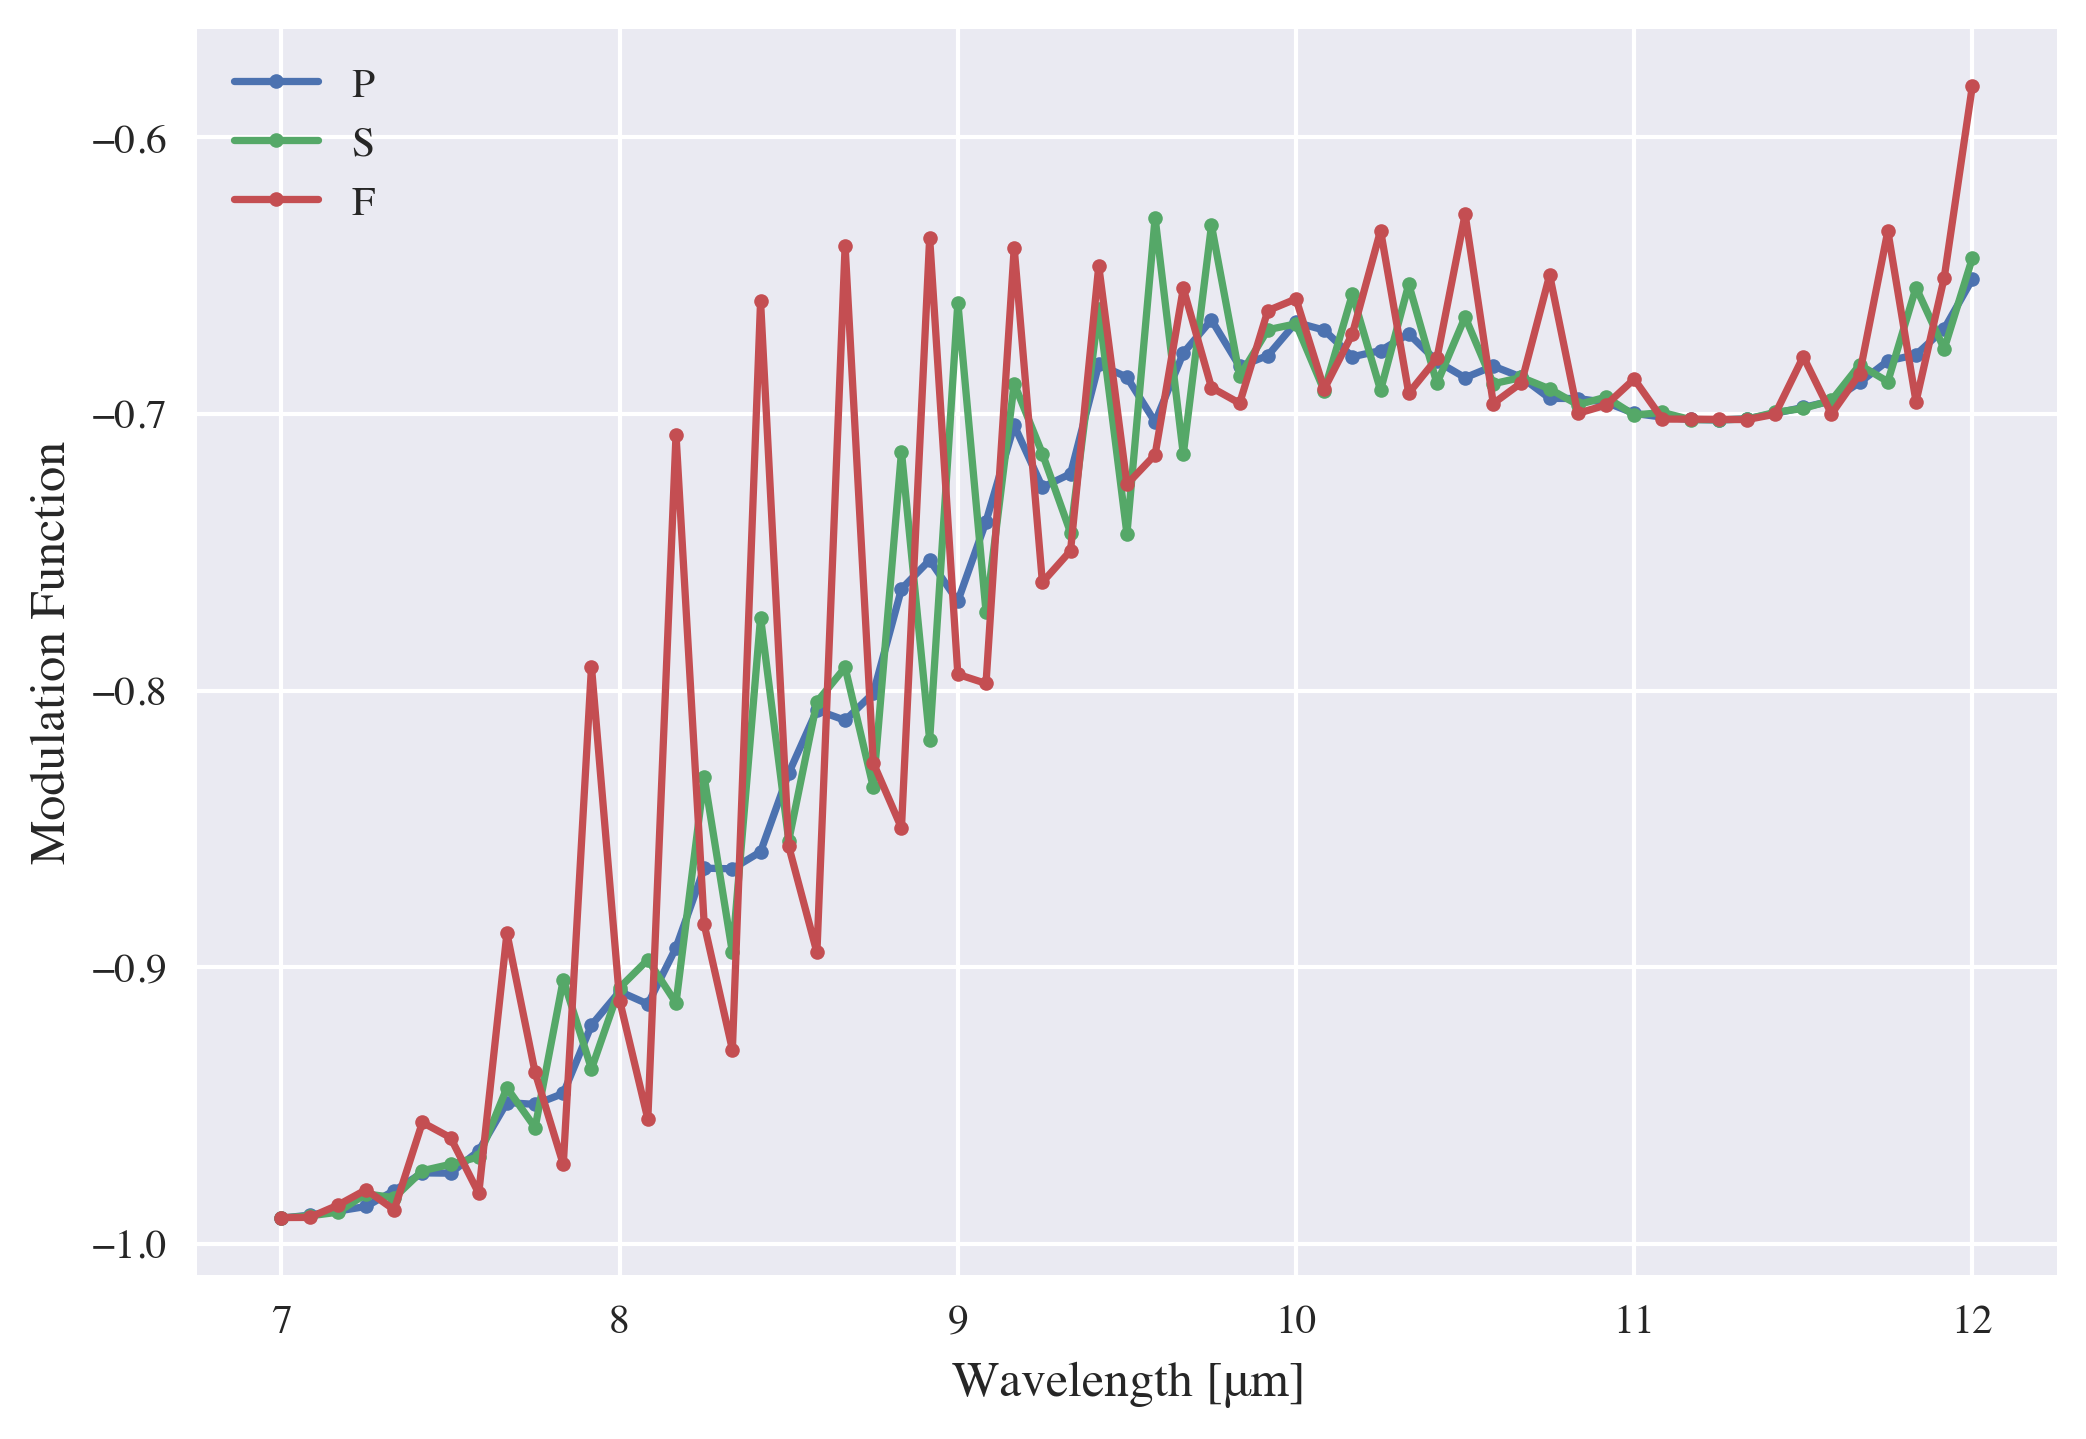

In [662]:
N = 1000;
wls = np.linspace(7,12,61)
plt.plot(wls,mod(1,5.01)[0],'.-',label = '1')
plt.plot(wls,mod(3,5.01)[0],'.-',label = '3')
plt.plot(wls,mod(5,5.01)[0],'.-',label = '5')

plt.ylabel("Modulation Function")
plt.xlabel('Wavelength [$\mathdefault{\mu m}$]')
plt.legend("PSF Width")
plt.gcf().set_dpi(300)

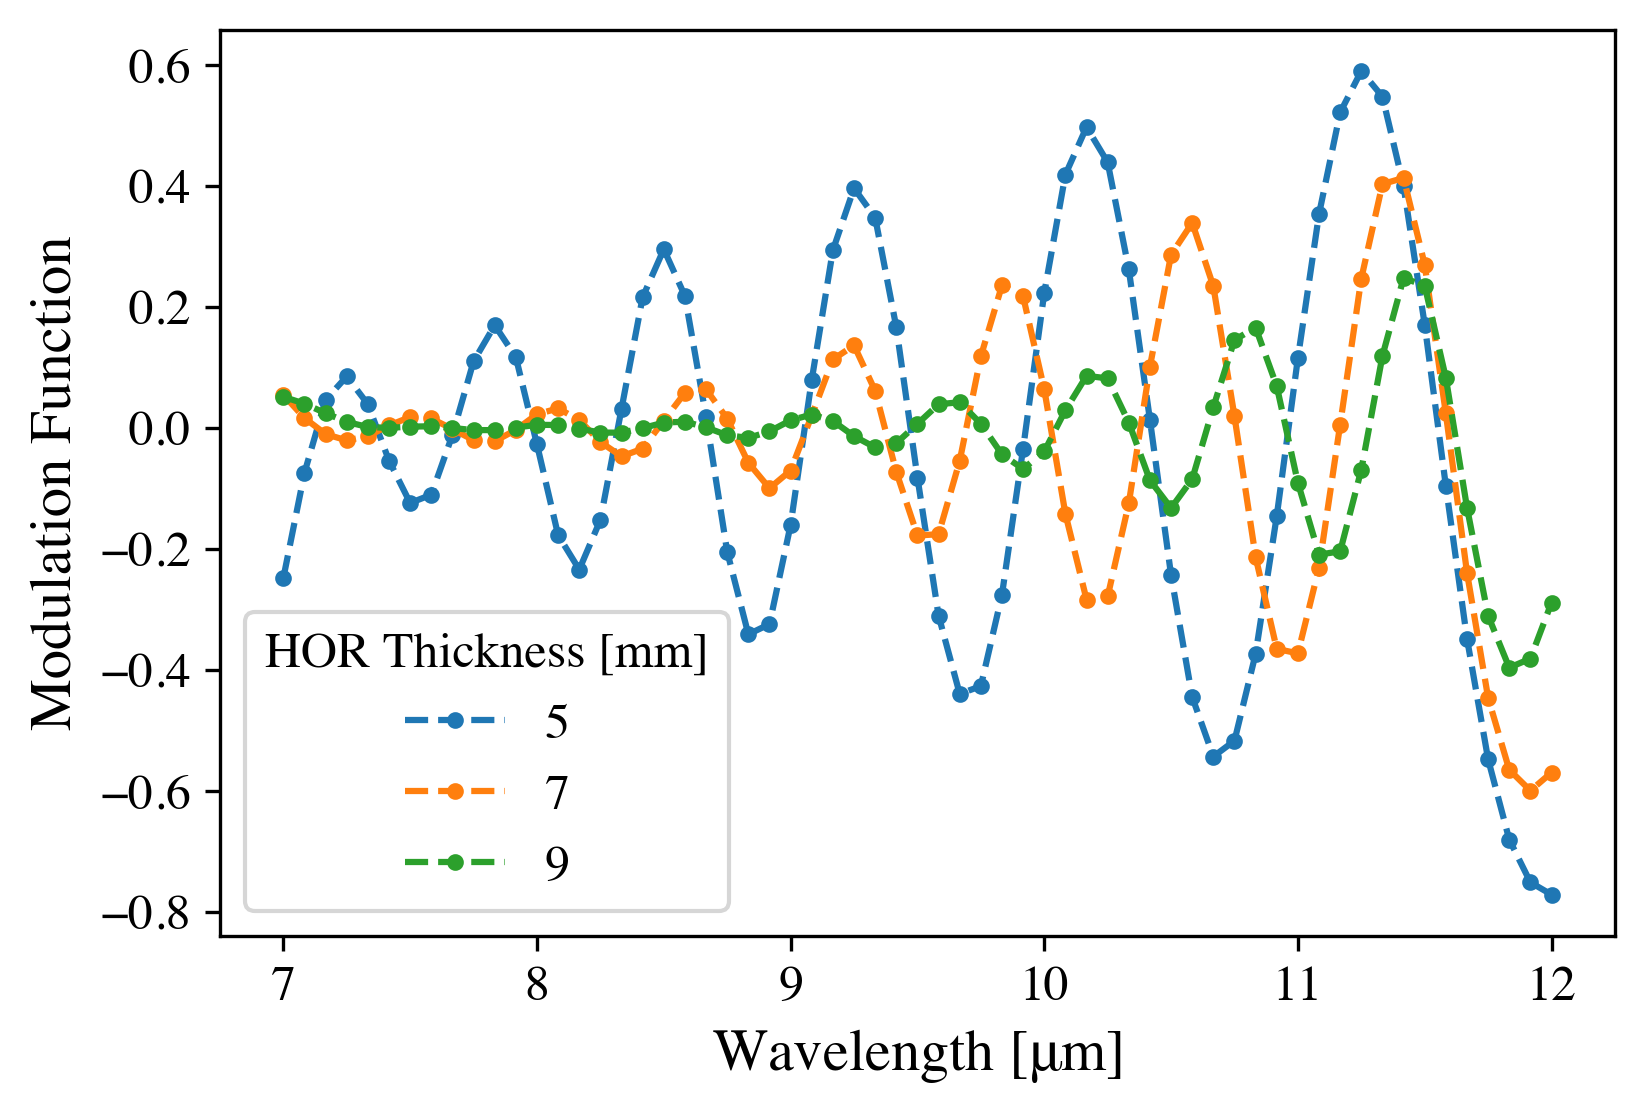

In [314]:
N = 61;

plt.plot(wls,mod(6,5.01)[0],'.--',label = '5')
#plt.plot(np.linspace(7,12,200),mod_continuous(5.01),'r',label = 'Discrete')
plt.plot(wls,mod(6,7.01),'.--',label = '7')
#plt.plot(np.linspace(7,12,200),mod_continuous(7.01),'b',label = 'Discrete')
plt.plot(wls,mod(6,9.01),'.--',label = '9')

plt.ylabel("Modulation Function")
plt.xlabel('Wavelength [$\mathdefault{\mu m}$]')
#plt.title("t = 7.01 mm")
plt.legend(title = "HOR Thickness [mm]")
plt.gcf().set_dpi(300)

In [408]:
angles = np.linspace(0,np.pi,180)
eff = np.zeros([61,61])
thicks = np.linspace(.1,10,61);
for t in range(61):
    cal = np.zeros([180,61])
    mag = np.zeros([180,61])
    for i in range(180):
        cal[i],mag[i] = mod(thicks[t],5.01,aolp = angles[i])
       
    eff[t] = np.max(cal)

/Users/kirahart/opt/anaconda3/envs/database/lib/python3.7/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """Entry point for launching an IPython kernel.


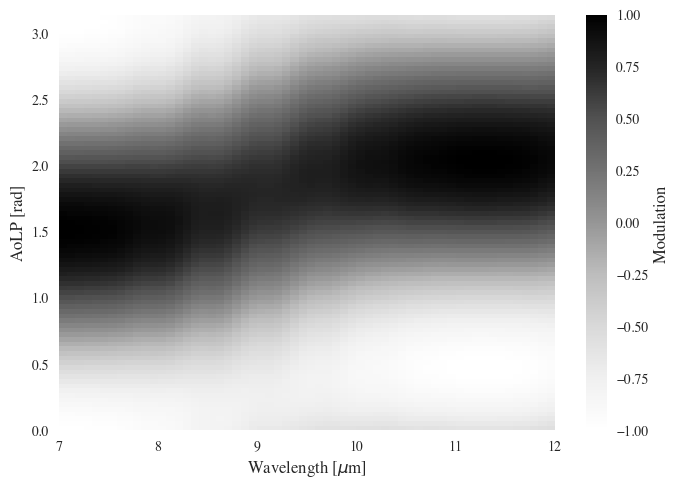

TypeError: Dimensions of C (61, 10) are incompatible with X (61) and/or Y (10); see help(pcolormesh)

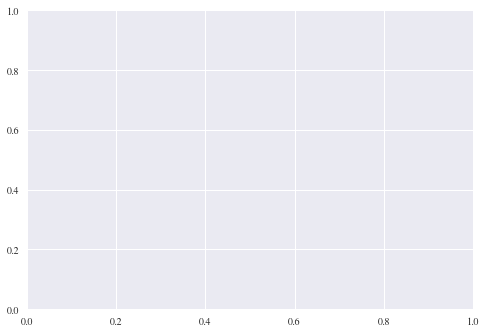

In [681]:
plt.pcolormesh(wls, angles,cal,vmin = -1,vmax = 1, cmap = "Greys")
plt.ylabel("AoLP [rad]")
plt.xlabel("Wavelength [$\mu$m]")
plt.colorbar(label = "Modulation ")
plt.gcf().set_dpi(100)
plt.show()

plt.pcolormesh(wls, thicks, eff ,vmin = 0,vmax = 1, cmap = "Greys")
plt.ylabel("Slit Dimension")
plt.xlabel("Wavelength [$\mu$m]")
plt.colorbar(label = "Efficiency ")
plt.gcf().set_dpi(100)
plt.show()



In [682]:
samp = 10
angles = np.linspace(0,np.pi,90)
eff = np.zeros([61,samp])
thicks = np.linspace(3,8,samp)
for t in range(samp):
    cal = np.zeros([90,61])
    mag = np.zeros([90,61])
    for i in range(90):
        cal[i],mag[i] = mod(2,thicks[t],aolp = angles[i])
       
    eff[:,t] = np.max(cal,axis = 0)

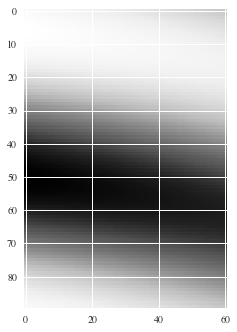

In [683]:
plt.imshow(cal)

TypeError: Dimensions of C (90, 61) are incompatible with X (10) and/or Y (61); see help(pcolormesh)

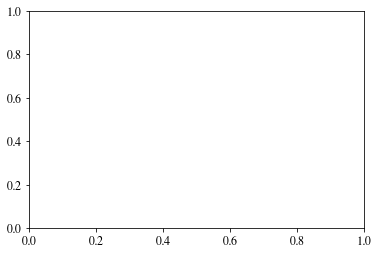

In [516]:

plt.pcolormesh(thicks,wls,cal)
plt.ylabel("Spot Size (pixels)")
plt.xlabel("CdSe Thickness (mm)")
plt.title("Maximum DoLP Precision \n 11 micron , $T_b = $ 300K")
plt.colorbar(label = "[%]")
plt.gcf().set_dpi(300)
plt.show()

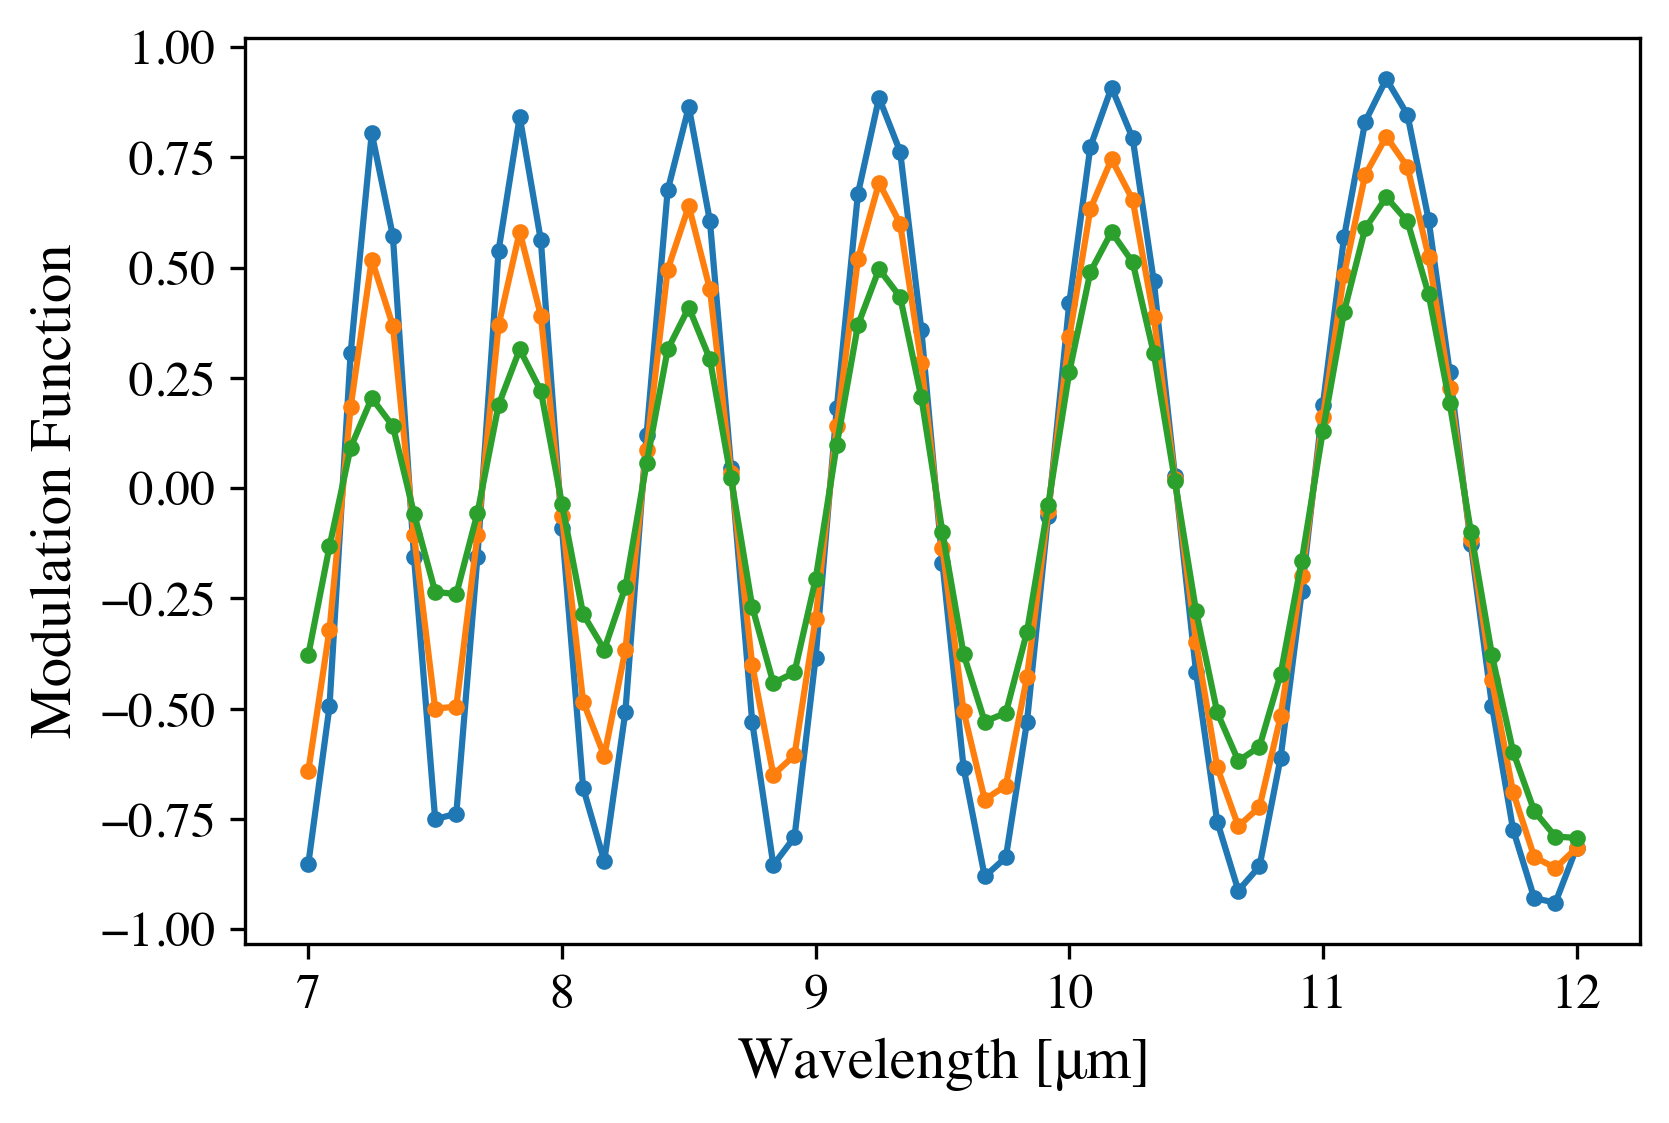

In [315]:
N = 1000;
wls = np.linspace(7,12,61)
plt.plot(wls,mod(1,5.01),'.-',label = '1')
plt.plot(wls,mod(3,5.01),'.-',label = '3')
plt.plot(wls,mod(5,5.01),'.-',label = '5')

plt.ylabel("Modulation Function")
plt.xlabel('Wavelength [$\mathdefault{\mu m}$]')
#plt.legend()
plt.gcf().set_dpi(300)

In [309]:
S1,S2 = path(5,3)

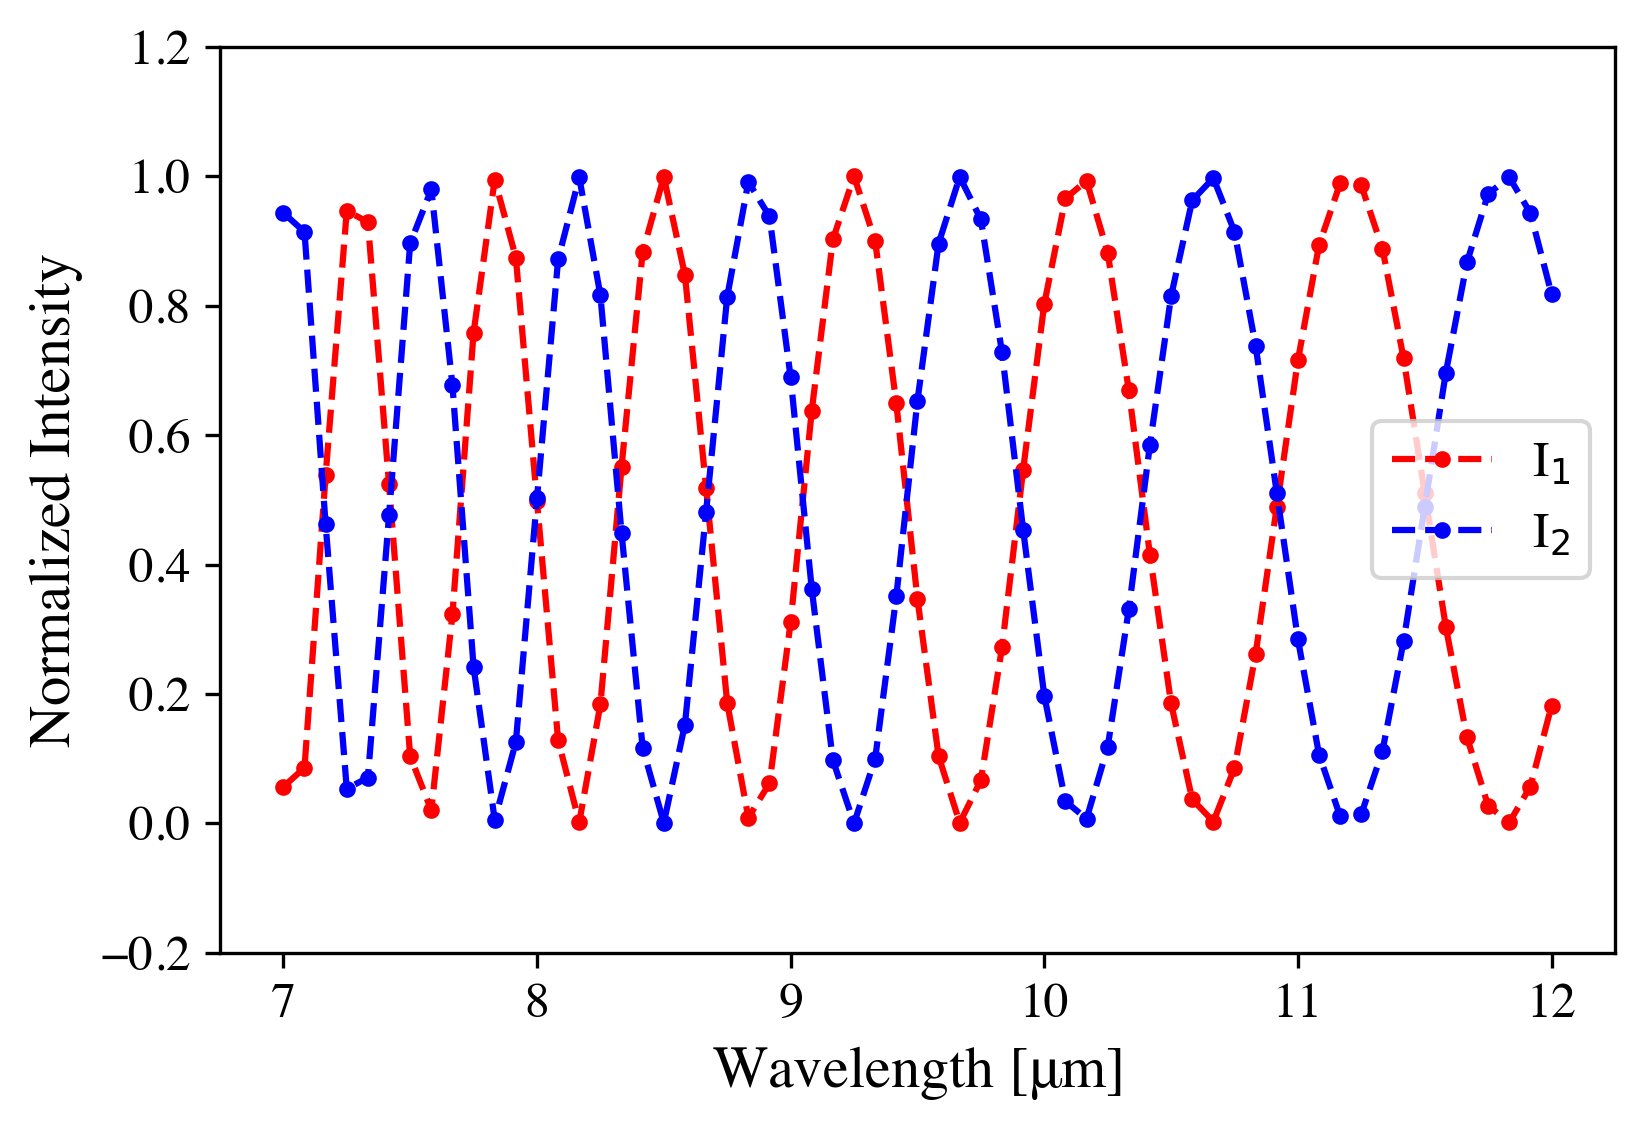

In [310]:
N = 1000;
wls = np.linspace(7,12,61)
plt.plot(wls,S1/2,'r.--',label = 'I$_1$')
plt.plot(wls,S2/2,'b.--',label = 'I$_2$')

plt.ylabel("Normalized Intensity")
plt.xlabel('Wavelength [$\mathdefault{\mu m}$]')
plt.legend()
plt.ylim(-.2,1.2)
plt.gcf().set_dpi(300)

In [30]:
import requests

response = requests.get('http://www.gemini.edu/sciops/ObsProcess/obsConstraints/atm-models/mktrans_nq_10_20.dat')
data = response.text 

data_by_line = data.split('\n')
for i in range(0,len(data_by_line)):
   data_by_line[i] = ' '.join(data_by_line[i].split())
   data_by_line[i] = data_by_line[i].split(' ')

In [31]:
w = np.zeros(600)
t = np.zeros(600)
for i in range(0,60000,100):
    j = int(i/100)
    float_lst = list(np.float_(data_by_line[i]))
    w[j] = float_lst[0]
    t[j] = float_lst[1]

In [32]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

transmissions = []
for ws in wls:
    idx = find_nearest(w,ws)
    ts = t[idx]
    transmissions.append(ts)
    
def path(width,thick):
    S1 = np.zeros(61*res)
    S2 = np.zeros(61*res)
    for l in np.linspace(7,12,10000):
        idx = find_nearest(w,l)
        ts = t[idx]
        
        i1 = I1(l,thick)*ts
        i2 = I2(l,thick)*ts
        S1 = S1 + i1*PSF(l,width)
        S2 = S2 + i2*PSF(l,width)
    N = 1000;
    S1 = average(S1, N)
    S2 = average(S2, N)
    return([S1,S2])

In [33]:
S1,S2 = path(5,5)

NameError: name 'average' is not defined

In [ ]:
fig ,ax = plt.subplots(3,figsize = (10,6),sharex = True)

ax[1].plot(wls,S1,'r.--', label = "I$_1$",markersize = 10)
ax[1].plot(wls,S2,'b.--',label = "I$_2$",markersize = 10)
ax[1].set_ylabel('Counts [ADU]')

ax[0].plot(w,t*100,'k')
ax[0].set_ylabel('T [%]')
#ax[0].set_xlabel('(a) Atmospheric Transmission')
#ax[1].set_xlabel('(b) Measured Spectrum')

ax[2].set_ylabel('M')
plt.xlabel('Wavelength [$\mathdefault{\mu m}$]')
ax[1].legend()
plt.gcf().set_dpi(300)
ax[2].set_xlim(7,12)
ax[2].plot(wls, (S1-S2)/(S1+S2),'k.',markersize = 10)

(7.0, 12.0, -1.1, 1.1)

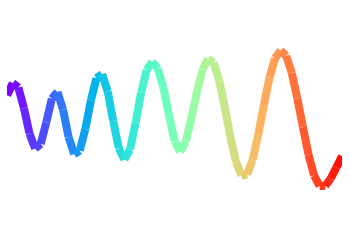

In [449]:
from matplotlib.collections import LineCollection

x = wls
y = (S1-S2)/(S1+S2)


#remember, slicing is upper bound exclusive, so we say i+2 when we mean the "i+1th" element
segments = [np.column_stack([x[i:i+2], y[i:i+2]]) for i in range(len(x) - 1)]
#this list has shape (200, 2, 2), so 200 lines with 2 points for 2 variables

fig, ax = plt.subplots()

ax.axis([7,12,-1.1,1.1]) #set axis limits. This is [xlow, xhigh, ylow, yhigh]

lc = LineCollection(segments, cmap='rainbow',array=wls,linewidth=8)
line = ax.add_collection(lc)
plt.xlabel('[$\mathdefault{\mu m}$]')
plt.axis('off')

In [37]:
def grating(f,d,wave):
    beta = np.arcsin(wave/d)
    return(np.cos(beta)*d/f)

In [38]:
disp = list(map(lambda x: grating(6.3e3,30,x), wls))

Text(0, 0.5, 'wavelength/ pixel [$\\mu m$]')

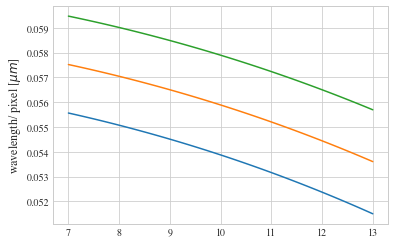

In [39]:
for period in [30,31,32]:
    disp = list(map(lambda x: 12*grating(6.3e3,period,x), wls))
    plt.plot(wls,disp)
plt.ylabel("wavelength/ pixel [$\mu m$]")

In [40]:
ret5 = list(map(lambda x: retardance(x,5.01)/x, wls))
ret6 = list(map(lambda x: retardance(x,7.01)/x, wls))
ret9 = list(map(lambda x: retardance(x,9.01)/x, wls))

fqs = 10**4/(wls)
df5 =-np.diff(ret5)/np.diff(wls)
df6 =-np.diff(ret6)/np.diff(wls)

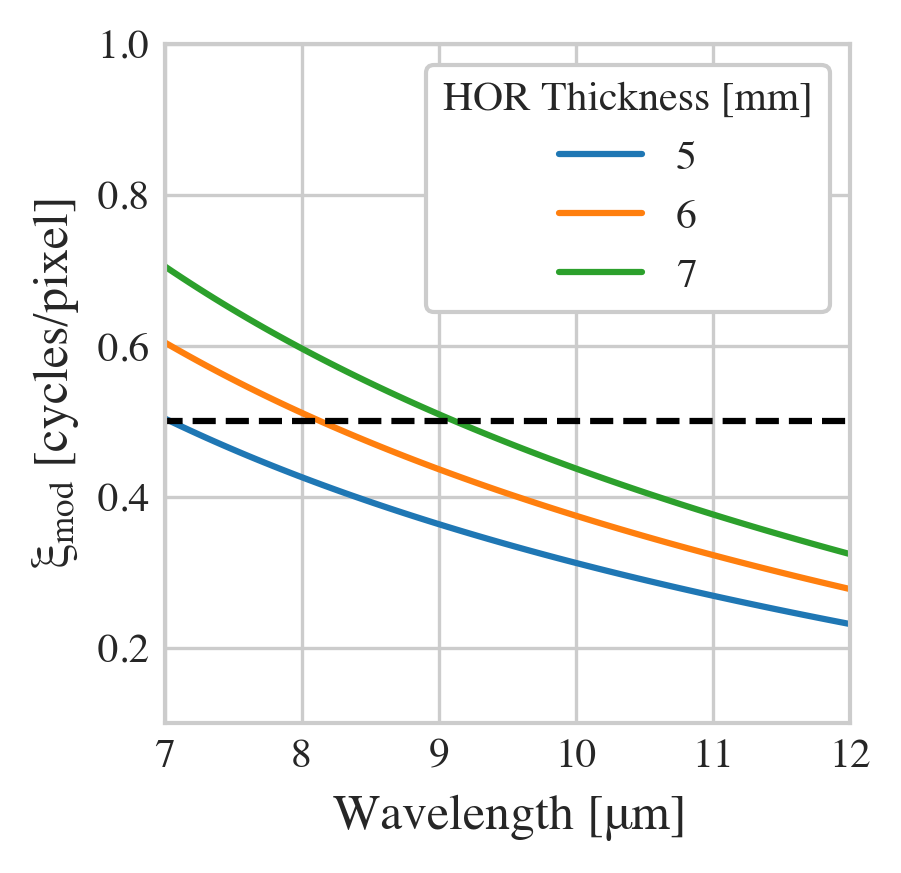

In [46]:
thick = 5
period = 20

fig = plt.subplots(1,figsize = (textwidth/2,3))

for thick in [5,6,7]:
    ret = list(map(lambda x: retardance(x,thick)/x, wls))
    df = -np.diff(ret)/np.diff(wls)
    
    disp = list(map(lambda x: 12 * grating(6e3,period,x), wls))
    plt.plot(wls,np.multiply(disp,ret),label = str(thick))
    
    
plt.ylabel('$\mathdefault{\\xi_{mod}}$ [cycles/pixel]')
plt.xlabel('Wavelength [$\mathdefault{\mu m}$]')
legend = plt.legend(title = "HOR Thickness [mm]",framealpha=1, frameon=True)
legend.get_frame().set_facecolor('w')

plt.xlim(7,12)
plt.ylim(.1,1)

plt.plot([6,13],[.5,.5],'k--')
plt.gcf().set_dpi(300)